In [1]:
from conditions import DirectTaskCondition, InverseTaskCondition
from models import ModelWithMeasure, ModelWithMeasureWithoutOxy
from solvers import DirectTaskSolverRK45, InverseTaskSolverDE
from shower import Shower
from residual_functions import residual_function_without_oxy, residual_function_without_oxy_reg_linear

import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
ph = pd.read_excel('2016_phyto_0-50.xlsx')

In [3]:
ph

дата  горизонт, м  численность, тыс.кл/л  численность, млн.кл/л  \
0   2016-02-19            0               15329.66               15.32966   
1   2016-02-19            5               16980.91               16.98091   
2   2016-02-19           10               12110.82               12.11082   
3   2016-02-19           25               11509.93               11.50993   
4   2016-02-19           50                6028.02                6.02802   
..         ...          ...                    ...                    ...   
159 2016-12-06            0                7125.58                7.12558   
160 2016-12-06            5                7083.51                7.08351   
161 2016-12-06           10                6022.89                6.02289   
162 2016-12-06           25               15379.94               15.37994   
163 2016-12-06           50                  14.57                0.01457   

     биомасса, мг/л  биомасса, мг/м^3  Unnamed: 6  безразмерное  
0          7.664830          7664.830         NaN      1.000000  
1          8.490455          8490.455         NaN      1.107716  
2          6.055410          6055.410         NaN      0.790025  
3          5.754965          5754.965         NaN      0.750827  
4          3.014010          3014.010         NaN      0.393226  
..              ...               ...         ...           ...  
159        3.562790          3562.790         NaN      0.464823  
160        3.541755          3541.755         NaN      0.462079  
161        3.011445          3011.445         NaN      0.392891  
162        7.689970          7689.970         NaN      1.003280  
163        0.007285             7.285         NaN      0.000950  

[164 rows x 8 columns]

In [4]:
ph = pd.read_excel('2016_phyto_0-50.xlsx')

ph = ph.rename(columns={'дата': 'date', 'горизонт, м': 'depth', 'численность, млн.кл/л': 'value'})
ph = ph[['date', 'depth', 'value']].copy()
ph['depth'] = ph['depth'].astype(str)
ph = ph.groupby(['date', 'depth'])['value'].mean().unstack().reset_index()
ph['date'] = pd.to_datetime(ph['date'])
ph = ph.sort_values(by=['date']).reset_index(drop=True)
ph = ph.ffill(axis=0)

ph['0-10_sum'] = ph['0'] + ph['5'] + ph['10']
ph['10-25_sum'] = ph['10'] + ph['25']
ph['25-50_sum'] = ph['25'] + ph['50']
ph['t'] = (ph['date'].dt.date - ph['date'].dt.date.iloc[0]).apply(lambda x: x.days)
ph


depth       date          0        10        25         5        50  \
0     2016-02-19  15.329660  12.11082  11.50993  16.98091   6.02802   
1     2016-02-25  17.105900  14.83569  12.27858  16.34453   5.87762   
2     2016-03-03  15.162520  16.08892  11.34201  15.54425   7.17910   
3     2016-03-11  15.777440  16.65935   7.85863  16.62169   4.91460   
4     2016-03-16  24.813120  29.04244  16.94310  30.17624   8.97266   
5     2016-03-23  31.869240  31.79121  28.98975  33.58528   3.64242   
6     2016-05-16  16.492650  11.65085  11.78343  16.49265  10.08629   
7     2016-05-23  10.133690  10.20163   9.40645  10.60699   6.25274   
8     2016-05-31   4.447360   4.79548   4.51905   4.69225   3.94760   
9     2016-06-06   5.940930   5.90783   4.62603   5.63650   3.70302   
10    2016-06-15   7.729450   7.64609   4.10028   6.94962   6.18431   
11    2016-06-22   7.998690   8.26057   6.63896   8.36754   5.37511   
12    2016-06-29   6.110650  12.29549   7.09135   9.30523   4.83105   
13    2016-07-06  26.403790  32.34647  16.29010  23.31277  11.77410   
14    2016-07-13   7.330890   5.89255   5.27054   6.69060   2.95831   
15    2016-07-20   5.809010   5.44399   8.89935   6.69060   2.25946   
16    2016-07-27  11.876050  11.25835   8.25283  12.32667   7.54389   
17    2016-08-03  14.524760  14.78385  13.61324  15.39816   7.81300   
18    2016-08-09  11.669670  12.78136  11.42810  13.35630  11.19381   
19    2016-08-18   7.836380   9.91930   5.71360  13.85611   3.24714   
20    2016-08-25  12.009060   0.06490   5.15890   5.44150   2.87247   
21    2016-09-06   4.288230   2.87891   3.70828   0.77642   3.13965   
22    2016-09-13   3.509100  18.15438   9.01769   4.14911   8.54956   
23    2016-09-20  14.167986   8.32419   4.39653  12.41080   7.18263   
24    2016-09-27   9.321520   1.76933  21.18312  16.94632   2.27711   
25    2016-10-06  16.599610  13.08050   8.07960  16.00095   2.74852   
26    2016-10-17  15.952860  26.48845  27.62349  22.22614   8.18711   
27    2016-10-24   4.708170  11.12094  14.35867  10.65469   7.97021   
28    2016-11-01   8.615230  19.34044  11.13335  19.69389  10.10095   
29    2016-11-10   3.107780  10.27020   8.75784  24.27771   7.69434   
30    2016-11-15  34.072540  18.89132  19.66235  18.01167  12.06223   
31    2016-11-22  17.652480   0.00537  15.23866   9.78672  13.13203   
32    2016-12-06   7.125580   6.02289  15.37994   7.08351   0.01457   

depth   0-10_sum  10-25_sum  25-50_sum    t  
0      44.421390   23.62075   17.53795    0  
1      48.286120   27.11427   18.15620    6  
2      46.795690   27.43093   18.52111   13  
3      49.058480   24.51798   12.77323   21  
4      84.031800   45.98554   25.91576   26  
5      97.245730   60.78096   32.63217   33  
6      44.636150   23.43428   21.86972   87  
7      30.942310   19.60808   15.65919   94  
8      13.935090    9.31453    8.46665  102  
9      17.485260   10.53386    8.32905  108  
10     22.325160   11.74637   10.28459  117  
11     24.626800   14.89953   12.01407  124  
12     27.711370   19.38684   11.92240  131  
13     82.063030   48.63657   28.06420  138  
14     19.914040   11.16309    8.22885  145  
15     17.943600   14.34334   11.15881  152  
16     35.461070   19.51118   15.79672  159  
17     44.706770   28.39709   21.42624  166  
18     37.807330   24.20946   22.62191  172  
19     31.611790   15.63290    8.96074  181  
20     17.515460    5.22380    8.03137  188  
21      7.943560    6.58719    6.84793  200  
22     25.812590   27.17207   17.56725  207  
23     34.902976   12.72072   11.57916  214  
24     28.037170   22.95245   23.46023  221  
25     45.681060   21.16010   10.82812  230  
26     64.667450   54.11194   35.81060  241  
27     26.483800   25.47961   22.32888  248  
28     47.649560   30.47379   21.23430  256  
29     37.655690   19.02804   16.45218  265  
30     70.975530   38.55367   31.72458  270  
31     27.444570   15.24403   28.37069  277  
32     20.231980   21.40283   15.39451  291

In [12]:
ph = ph.loc[ph['t'].between(131, 221)].reset_index(drop=True).copy()
ph['t'] -= 131
ph

depth       date          0        10        25         5        50  \
0     2016-06-29   6.110650  12.29549   7.09135   9.30523   4.83105   
1     2016-07-06  26.403790  32.34647  16.29010  23.31277  11.77410   
2     2016-07-13   7.330890   5.89255   5.27054   6.69060   2.95831   
3     2016-07-20   5.809010   5.44399   8.89935   6.69060   2.25946   
4     2016-07-27  11.876050  11.25835   8.25283  12.32667   7.54389   
5     2016-08-03  14.524760  14.78385  13.61324  15.39816   7.81300   
6     2016-08-09  11.669670  12.78136  11.42810  13.35630  11.19381   
7     2016-08-18   7.836380   9.91930   5.71360  13.85611   3.24714   
8     2016-08-25  12.009060   0.06490   5.15890   5.44150   2.87247   
9     2016-09-06   4.288230   2.87891   3.70828   0.77642   3.13965   
10    2016-09-13   3.509100  18.15438   9.01769   4.14911   8.54956   
11    2016-09-20  14.167986   8.32419   4.39653  12.41080   7.18263   
12    2016-09-27   9.321520   1.76933  21.18312  16.94632   2.27711   

depth   0-10_sum  10-25_sum  25-50_sum   t  
0      27.711370   19.38684   11.92240   0  
1      82.063030   48.63657   28.06420   7  
2      19.914040   11.16309    8.22885  14  
3      17.943600   14.34334   11.15881  21  
4      35.461070   19.51118   15.79672  28  
5      44.706770   28.39709   21.42624  35  
6      37.807330   24.20946   22.62191  41  
7      31.611790   15.63290    8.96074  50  
8      17.515460    5.22380    8.03137  57  
9       7.943560    6.58719    6.84793  69  
10     25.812590   27.17207   17.56725  76  
11     34.902976   12.72072   11.57916  83  
12     28.037170   22.95245   23.46023  90

In [13]:
zoo = pd.read_excel('2016_zoo.xlsx')
zoo

слой (м)  2016-02-19 00:00:00  2016-02-25 00:00:00  2016-03-03 00:00:00  \
0     0-10            144.56250            241.20000             218.7000   
1    10-25            157.89375            174.15000             108.1800   
2    25-50            323.10000            243.84375             189.5625   
3      NaN                  NaN                  NaN                  NaN   
4      NaN                  NaN                  NaN                  NaN   
5      NaN             72.28125            120.60000             109.3500   

   2016-03-11 00:00:00  2016-03-16 00:00:00  2016-03-23 00:00:00  \
0              264.150             196.6500            278.43750   
1              123.075             272.2500             94.65750   
2              219.375             325.6875            271.01250   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   
5              132.075              98.3250            139.21875   

   2016-05-16 00:00:00  2016-05-23 00:00:00  2016-05-31 00:00:00  ...  \
0            176.06250              30.3750              26.3250  ...   
1            266.06250              97.8750             132.3000  ...   
2            350.43750             212.6250             184.5000  ...   
3                  NaN                  NaN                  NaN  ...   
4                  NaN                  NaN                  NaN  ...   
5             88.03125              15.1875              13.1625  ...   

   2016-09-20 00:00:00  2016-09-27 00:00:00  2016-10-06 00:00:00  \
0            678.37500              288.900              615.600   
1           1079.83125                3.375              424.575   
2           1317.60000              243.000             1019.700   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   
5            339.18750              144.450              307.800   

   2016-10-17 00:00:00  2016-10-24 00:00:00  2016-11-01 00:00:00  \
0             705.3750            758.36250            473.28750   
1            1000.3500            853.87500            699.30000   
2             799.2000           1175.85000            843.75000   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   
5             352.6875            379.18125            236.64375   

   2016-11-10 00:00:00  2016-11-15 00:00:00  2016-11-22 00:00:00  \
0               453.60              291.150             123.0750   
1               571.05              417.600             115.3125   
2               600.75              474.750             222.7500   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   
5               226.80              145.575              61.5375   

   2016-12-06 00:00:00  
0              53.3250  
1             115.7625  
2             196.2000  
3                  NaN  
4                  NaN  
5              26.6625  

[6 rows x 34 columns]

In [14]:
zoo = zoo.rename(
    columns={
        'слой (м)': 'depth'
    }
)
zoo = zoo.loc[:2, :].copy()
zoo = zoo.set_index('depth').T.reset_index().rename(columns={'index': 'date', ' 10-25': '10-25'})
zoo['date'] = pd.to_datetime(zoo['date'])
zoo = zoo.sort_values(by=['date']).reset_index(drop=True)
zoo['0-10'] /= 10
zoo['10-25'] /= 10
zoo['25-50'] /= 10
zoo['t'] = (zoo['date'].dt.date - zoo['date'].dt.date.iloc[0]).apply(lambda x: x.days)
zoo

depth       date        0-10       10-25       25-50    t
0     2016-02-19   14.456250   15.789375   32.310000    0
1     2016-02-25   24.120000   17.415000   24.384375    6
2     2016-03-03   21.870000   10.818000   18.956250   13
3     2016-03-11   26.415000   12.307500   21.937500   21
4     2016-03-16   19.665000   27.225000   32.568750   26
5     2016-03-23   27.843750    9.465750   27.101250   33
6     2016-05-16   17.606250   26.606250   35.043750   87
7     2016-05-23    3.037500    9.787500   21.262500   94
8     2016-05-31    2.632500   13.230000   18.450000  102
9     2016-06-06    8.859375   15.356250    2.430000  108
10    2016-06-15   30.442500   43.368750   15.558750  117
11    2016-06-22   48.352500   33.817500   17.550000  124
12    2016-06-29    8.550000   18.815625   15.086250  131
13    2016-07-06   17.758125   42.840000   13.871250  138
14    2016-07-13   20.868750   24.435000    6.553125  145
15    2016-07-20   57.060000  165.240000    8.797500  152
16    2016-07-27  133.110000  155.610000   30.240000  159
17    2016-08-03   89.381250  132.210000   68.850000  166
18    2016-08-09   48.465000  142.852500  234.360000  172
19    2016-08-18  107.887500  142.593750   90.669375  181
20    2016-08-25   32.085000   49.545000   50.310000  188
21    2016-09-06    9.315000   24.570000   26.212500  200
22    2016-09-13  107.190000  225.517500   84.915000  207
23    2016-09-20   67.837500  107.983125  131.760000  214
24    2016-09-27   28.890000    0.337500   24.300000  221
25    2016-10-06   61.560000   42.457500  101.970000  230
26    2016-10-17   70.537500  100.035000   79.920000  241
27    2016-10-24   75.836250   85.387500  117.585000  248
28    2016-11-01   47.328750   69.930000   84.375000  256
29    2016-11-10   45.360000   57.105000   60.075000  265
30    2016-11-15   29.115000   41.760000   47.475000  270
31    2016-11-22   12.307500   11.531250   22.275000  277
32    2016-12-06    5.332500   11.576250   19.620000  291

In [15]:
zoo = zoo.loc[zoo['t'].between(131, 221)].reset_index(drop=True).copy()
zoo['t'] -= 131
zoo

depth       date        0-10       10-25       25-50   t
0     2016-06-29    8.550000   18.815625   15.086250   0
1     2016-07-06   17.758125   42.840000   13.871250   7
2     2016-07-13   20.868750   24.435000    6.553125  14
3     2016-07-20   57.060000  165.240000    8.797500  21
4     2016-07-27  133.110000  155.610000   30.240000  28
5     2016-08-03   89.381250  132.210000   68.850000  35
6     2016-08-09   48.465000  142.852500  234.360000  41
7     2016-08-18  107.887500  142.593750   90.669375  50
8     2016-08-25   32.085000   49.545000   50.310000  57
9     2016-09-06    9.315000   24.570000   26.212500  69
10    2016-09-13  107.190000  225.517500   84.915000  76
11    2016-09-20   67.837500  107.983125  131.760000  83
12    2016-09-27   28.890000    0.337500   24.300000  90

In [8]:
depth = '0-10'

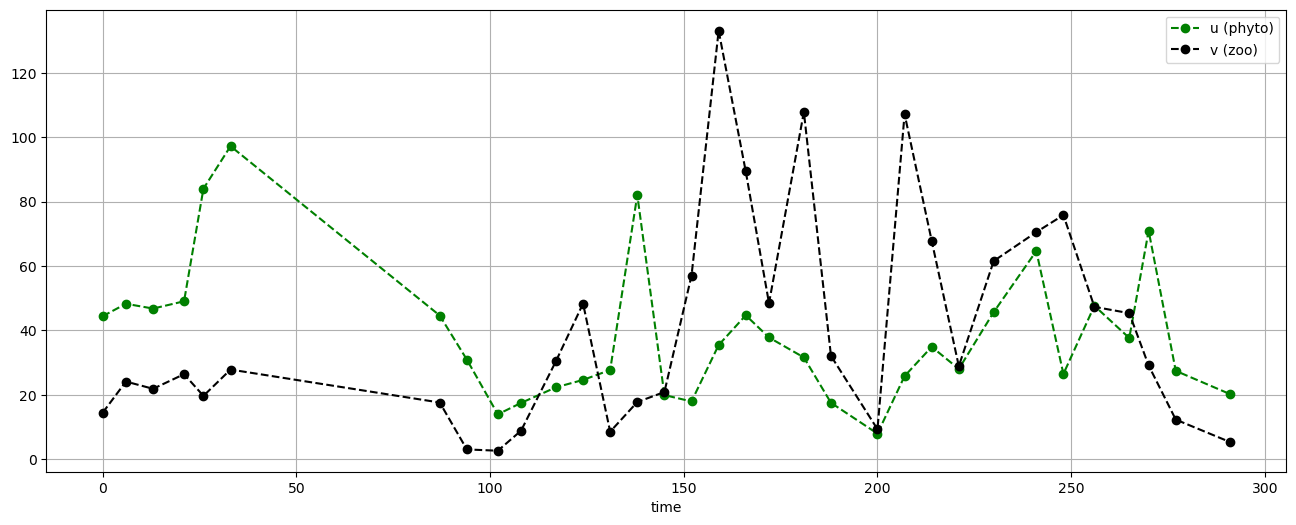

In [9]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(ph['t'], ph[f'{depth}_sum'], label='u (phyto)', marker='o', linestyle='--', color='green')
ax.plot(zoo['t'], zoo[f'{depth}'], label='v (zoo)', marker='o', linestyle='--', color='black')
ax.grid()
ax.set_xlabel('time')
ax.legend()

In [13]:
solution = {
    't': list(ph['t'].values),
    'y': list(([0.1, 150], list(ph[f'{depth}_sum'].values), list(zoo[f'{depth}'].values)))
}

initial_data = ['no', solution['y'][1][0], solution['y'][2][0]]
left_time_border = solution['t'][0]
right_time_border = solution['t'][-1]
time_grid = solution['t']

bounds_with_oxy = [(0.001, 500), (0.001, 500), (0.001, 500), (0.001, 500),
          (0.001, 500), (0.001, 500), (0.001, 500), (0.001, 500),
          (0.001, 500), (0.001, 500), (0.001, 500), (0.001, 1),
          (0.001, 500), (0.001, 500), (0.001, 500), (0.001, 500), (0.001, 500)]

# bounds_with_oxy = [(0.0001, 1000), (0.0001, 1000), (0.0001, 1000), (0.0001, 1000),
#           (0.0001, 1000), (0.0001, 1000), (0.0001, 1000), (0.0001, 1000),
#           (0.0001, 1000), (0.0001, 1000), (0.0001, 1000), (0.0001, 1),
#           (0.0001, 1000), (0.0001, 1000), (0.0001, 1000), (0.0001, 1000), (0.0001, 1000)]

# bounds_with_oxy = [(0.0001, 100), (0.0001, 100), (0.0001, 100), (0.0001, 100),
#           (0.0001, 100), (0.0001, 100), (0.0001, 100), (0.0001, 100),
#           (0.0001, 100), (0.0001, 100), (0.0001, 100), (0.0001, 1),
#           (0.0001, 100), (0.0001, 100), (0.0001, 100), (0.0001, 100), (0.0001, 200)]

max_iter = 5
popsize = 150
# mutation = 1.5

In [14]:
initial_data

['no', 44.42139, 14.45625]

In [15]:
inverse_solutions = []
 
for seed in [167]:

    inverse_task_condition = InverseTaskCondition(
        solution,
        left_time_border,
        right_time_border,
        time_grid,
        bounds_with_oxy,
        max_iter,
        popsize,
        seed,
#         mutation,
    )
    
    inverse_task_solver = InverseTaskSolverDE(ModelWithMeasureWithoutOxy, residual_function_without_oxy)
#     inverse_task_solver = InverseTaskSolverDE(ModelWithMeasureWithoutOxy, residual_function_without_oxy_reg_linear)
    
    
    start = time.time()
    print('Start inverse task solution.\n')
    
    inverse_solution = inverse_task_solver.get_solution(inverse_task_condition)
    
    execution_time = round((time.time() - start)/60, 2)
    print(f'End inverse task solution.\n Execution time: {execution_time}min' )
    inverse_solutions.append(inverse_solution)

Start inverse task solution.

differential_evolution step 1: f(x)= 107273.59049566407
differential_evolution step 2: f(x)= 106620.29646468555
differential_evolution step 3: f(x)= 102715.63200609265
differential_evolution step 4: f(x)= 102715.63200609265
differential_evolution step 5: f(x)= 102715.63200609265
End inverse task solution.
 Execution time: 0.18min


In [43]:
dict(inverse_solutions[0])

{'x': array([3.64599062e+02, 1.53472685e+02, 2.61108409e+02, 2.07125242e+02,
        2.39083821e+02, 1.15031702e+02, 2.77194195e+02, 2.29551808e+02,
        4.84241041e+02, 1.20266866e+02, 4.25713079e+00, 4.74062148e-01,
        2.88667464e+02, 1.55018490e+01, 1.40014249e+00, 2.02108345e+02,
        5.57450000e+01]),
 'fun': 102715.63200609265,
 'nfev': 15300,
 'nit': 5,
 'message': 'Maximum number of iterations has been exceeded.',
 'success': False,
 'population': array([[364.59906154, 153.47268506, 261.10840855, ...,   1.40014249,
         202.10834549,  55.74499996],
        [318.44798914, 202.24130157, 338.32424926, ..., 112.25179778,
          97.42619211,  77.91092572],
        [366.86398969, 211.42417986, 339.4629715 , ..., 309.56101079,
         137.34264285,  51.84875624],
        ...,
        [186.07871505, 350.72190099, 388.62140111, ..., 391.54777685,
          63.036137  , 161.15055073],
        [447.06965878, 106.36417099,   5.68844917, ..., 117.4043156 ,
         173.77

In [16]:
result, data = inverse_solutions[0].x.copy(), solution

model = ModelWithMeasureWithoutOxy(*result)

direct_task_condition_new = DirectTaskCondition(
    initial_data,
    left_time_border,
    right_time_border,
    time_grid,
)

direct_task_condition_new.initial_data[0] = model.c_0

In [17]:
result

array([3.64599062e+02, 1.53472685e+02, 2.61108409e+02, 2.07125242e+02,
       2.39083821e+02, 1.15031702e+02, 2.77194195e+02, 2.29551808e+02,
       4.84241041e+02, 1.20266866e+02, 4.25713079e+00, 4.74062148e-01,
       2.88667464e+02, 1.55018490e+01, 1.40014249e+00, 2.02108345e+02,
       5.57450000e+01])

In [18]:
model

In [19]:
direct_solver = DirectTaskSolverRK45(model)

solution_new = direct_solver.get_solution(direct_task_condition_new)

In [44]:
solution_new

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [  0   6 ... 277 291]
        y: [[ 5.574e+01  1.538e+02 ...  1.538e+02  1.538e+02]
            [ 4.442e+01  3.988e+01 ...  3.988e+01  3.988e+01]
            [ 1.446e+01  4.723e-17 ... -5.337e-21  1.068e-23]]
      sol: None
 t_events: None
 y_events: None
     nfev: 210
     njev: 3
      nlu: 32

In [21]:
shower = Shower()

In [38]:
str(pd.Timestamp.now().round('min'))

'2024-05-01 19:34:00'

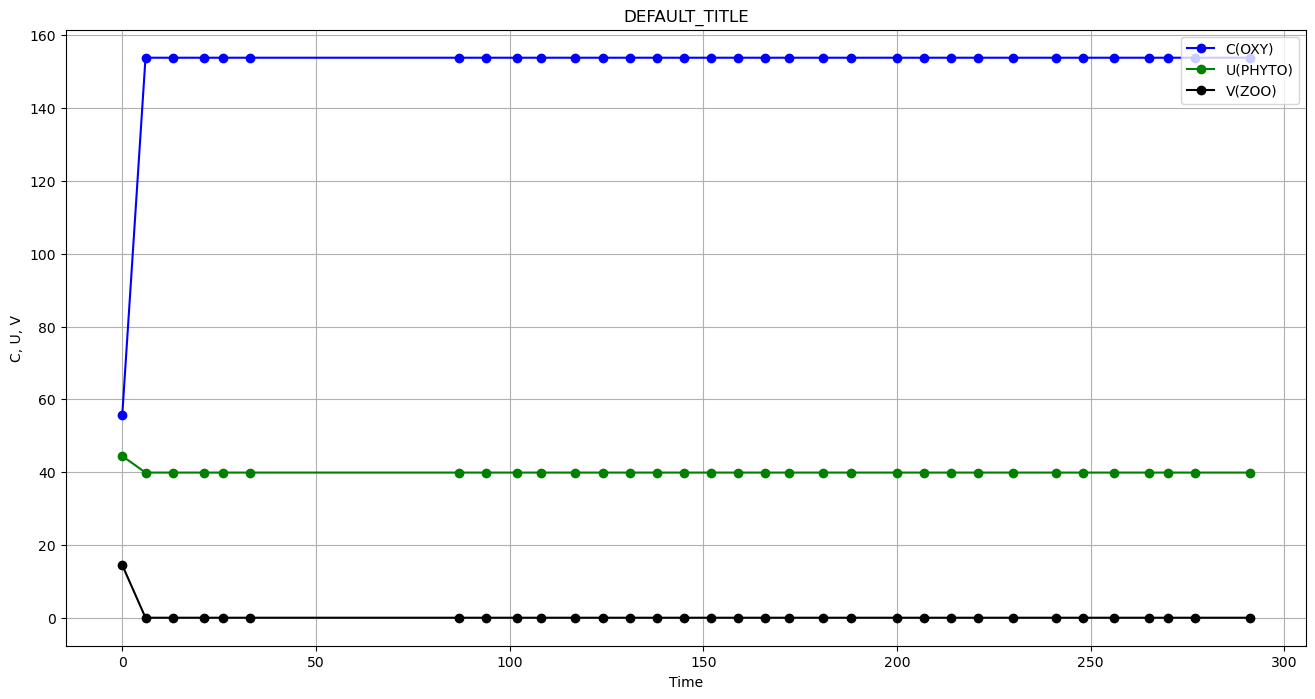

In [24]:
shower.show_solution(solution_new)
plt.savefig('foo.png')

(<Figure size 1600x800 with 1 Axes>, <Axes: xlabel='Time', ylabel='C, U, V'>)

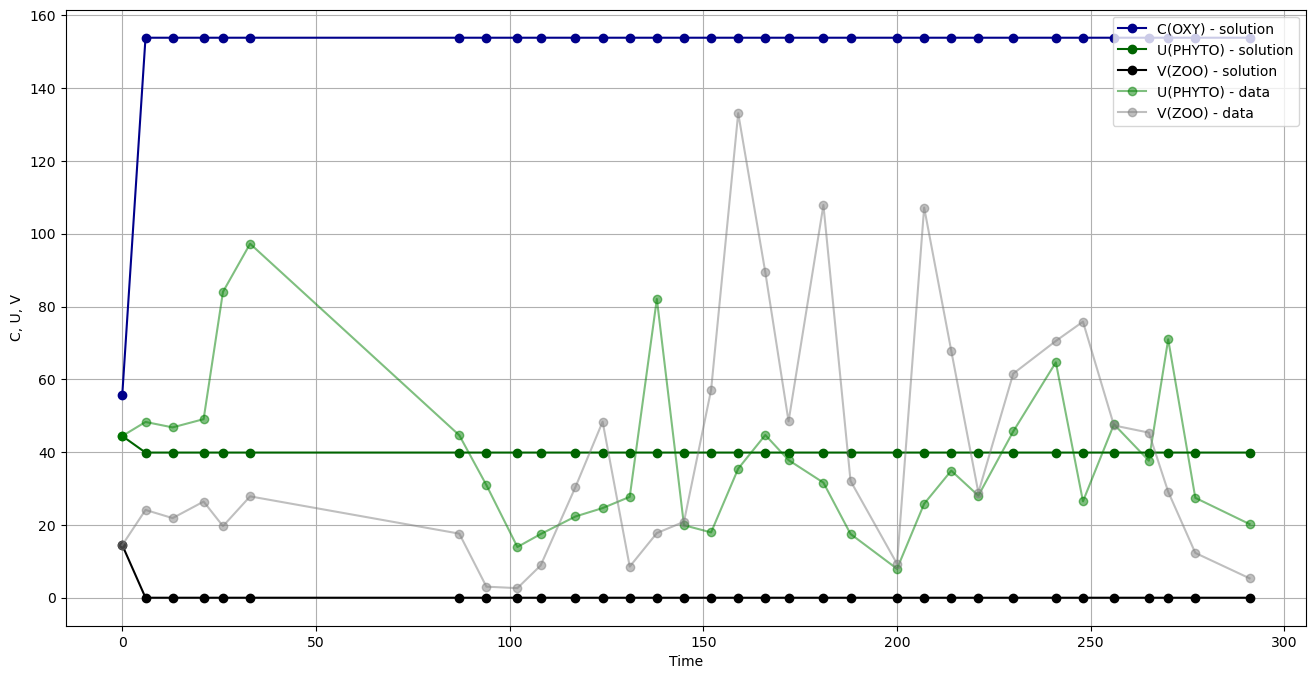

In [23]:
shower.show_solution_and_data_without_oxy(solution_new, data)

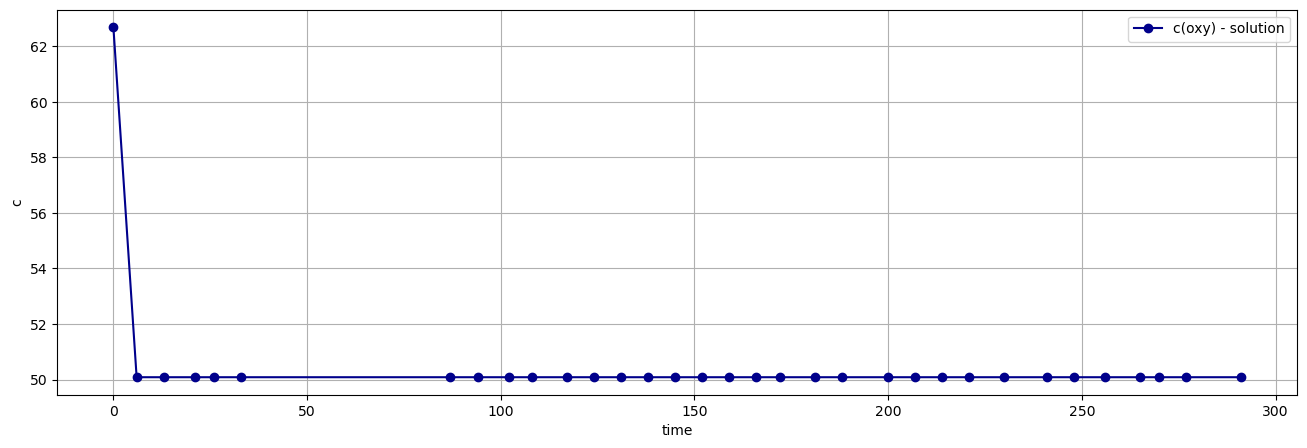

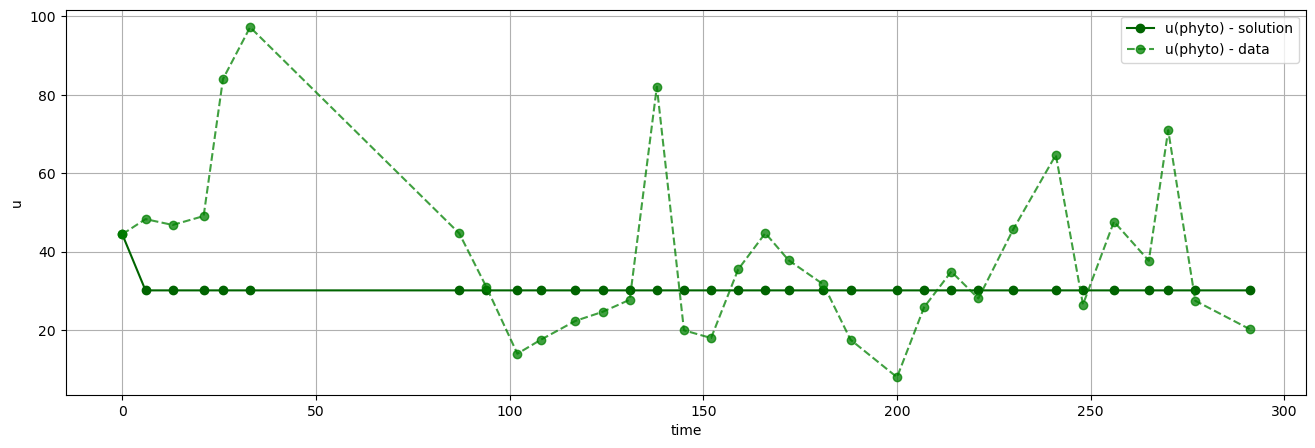

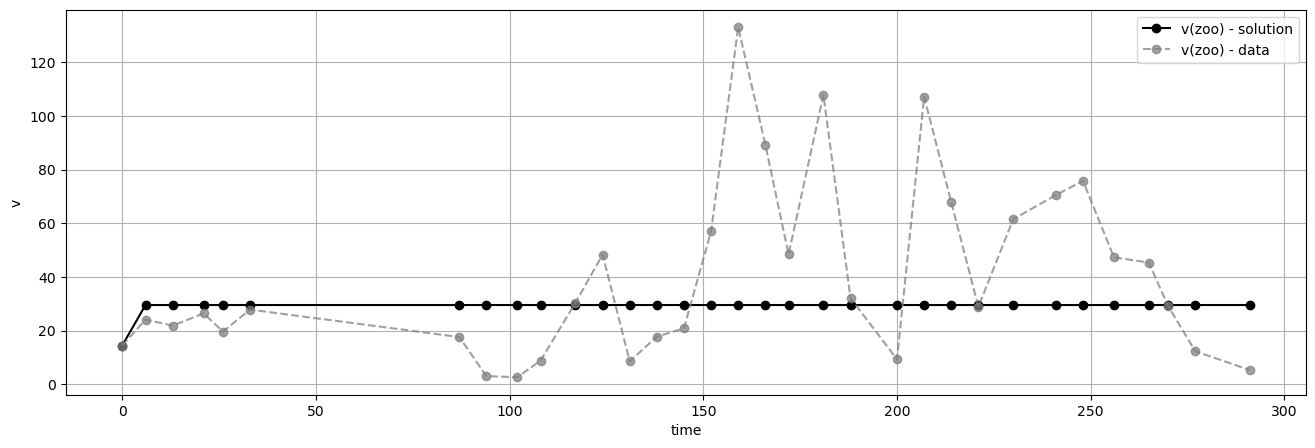

In [74]:
shower.show_solution_and_data_without_oxy_split(solution_new, data)

In [44]:
class Shower:
    """
    TODO
    """
    
    def show_solution(self, solution: dict, title='DEFAULT_TITLE'):
        """
        TODO
        """
        
        fig, gr = plt.subplots(figsize=(16, 8))

        gr.plot(solution['t'], solution['y'][0, :], '-o', color='blue', label='C(OXY)')
        gr.plot(solution['t'], solution['y'][1, :], '-o', color='green', label='U(PHYTO)')
        gr.plot(solution['t'], solution['y'][2, :], '-o', color='black', label='V(ZOO)')

        gr.legend(loc='upper right')
        gr.grid()
        gr.set_xlabel('Time')
        gr.set_ylabel('C, U, V')
        gr.set_title(title)
        
        return fig, gr
        
    def show_solution_and_data(self, solution: dict, data):
        """
        TODO
        """
        
        fig, gr = plt.subplots(figsize=(16, 8))

        gr.plot(solution['t'], solution['y'][0, :], '-o', color='darkblue', label='C(OXY) - solution')
        gr.plot(solution['t'], solution['y'][1, :], '-o', color='darkgreen', label='U(PHYTO) - solution')
        gr.plot(solution['t'], solution['y'][2, :], '-o', color='black', label='V(ZOO) - solution')

        gr.plot(data['t'], data['y'][0, :], '-o', color='blue', alpha=0.5, label='C(OXY) - data')
        gr.plot(data['t'], data['y'][1, :], '-o', color='green', alpha=0.5, label='U(PHYTO) - data')
        gr.plot(data['t'], data['y'][2, :], '-o', color='gray', alpha=0.5, label='V(ZOO) - data')

        gr.legend(loc='upper right')
        gr.grid()
        gr.set_xlabel('Time')
        gr.set_ylabel('C, U, V')

        return fig, gr

    def show_solution_and_data_without_oxy(self, solution: dict, data):
        """
        TODO
        """

        fig, gr = plt.subplots(figsize=(16, 8))

        gr.plot(solution['t'], solution['y'][0], '-o', color='darkblue', label='C(OXY) - solution')
        gr.plot(solution['t'], solution['y'][1], '-o', color='darkgreen', label='U(PHYTO) - solution')
        gr.plot(solution['t'], solution['y'][2], '-o', color='black', label='V(ZOO) - solution')

        gr.plot(data['t'], data['y'][1], '-o', color='green', alpha=0.5, label='U(PHYTO) - data')
        gr.plot(data['t'], data['y'][2], '-o', color='gray', alpha=0.5, label='V(ZOO) - data')

        gr.legend(loc='upper right')
        gr.grid()
        gr.set_xlabel('Time')
        gr.set_ylabel('C, U, V')

        return fig, gr

    def show_solution_and_data_without_oxy_split(self, solution: dict, data):
        """
        TODO
        """

        fig, gr = plt.subplots(3, 1, figsize=(16, 3))

        gr[0].plot(
            solution['t'],
            solution['y'][0],
            '-o',
            color='darkblue',
            label='c(oxy) - solution',
        )

        gr[0].legend()
        gr[0].grid()
        gr[0].set_xlabel('time')
        gr[0].set_ylabel('c')

        gr[1].plot(
            solution['t'],
            solution['y'][1],
            '-o',
            color='darkgreen',
            label='u(phyto) - solution',
        )

        gr[1].plot(
            data['t'],
            data['y'][1],
            marker='o',
            linestyle='--',
            color='green',
            alpha=0.75,
            label='u(phyto) - data',
        )

        gr.legend()
        gr.grid()
        gr.set_xlabel('time')
        gr.set_ylabel('u')

        fig, gr = plt.subplots(figsize=(16, 3))


        gr.plot(
            solution['t'],
            solution['y'][2],
            '-o',
            color='black',
            label='v(zoo) - solution',
        )

        gr.plot(
            data['t'],
            data['y'][2],
            marker='o',
            linestyle='--',
            color='gray',
            alpha=0.75,
            label='v(zoo) - data',
        )

        gr.legend()
        gr.grid()
        gr.set_xlabel('time')
        gr.set_ylabel('v')

In [85]:
time_grid

[0,
 6,
 13,
 21,
 26,
 33,
 87,
 94,
 102,
 108,
 117,
 124,
 131,
 138,
 145,
 152,
 159,
 166,
 172,
 181,
 188,
 200,
 207,
 214,
 221,
 230,
 241,
 248,
 256,
 265,
 270,
 277,
 291]

In [93]:
model = ModelWithMeasureWithoutOxy(*result)

direct_task_condition_new = DirectTaskCondition(
    initial_data,
    left_time_border,
    right_time_border,
    time_grid,
)

direct_task_condition_new.initial_data[0] = model.c_0
direct_task_condition_new.time_grid = list(range(0, 600, 14))
direct_task_condition_new.right_time_border = list(range(0, 600, 14))[-1]

In [95]:
direct_solver = DirectTaskSolverRK45(model)

solution_new = direct_solver.get_solution(direct_task_condition_new)

(<Figure size 1600x800 with 1 Axes>, <Axes: xlabel='Time', ylabel='C, U, V'>)

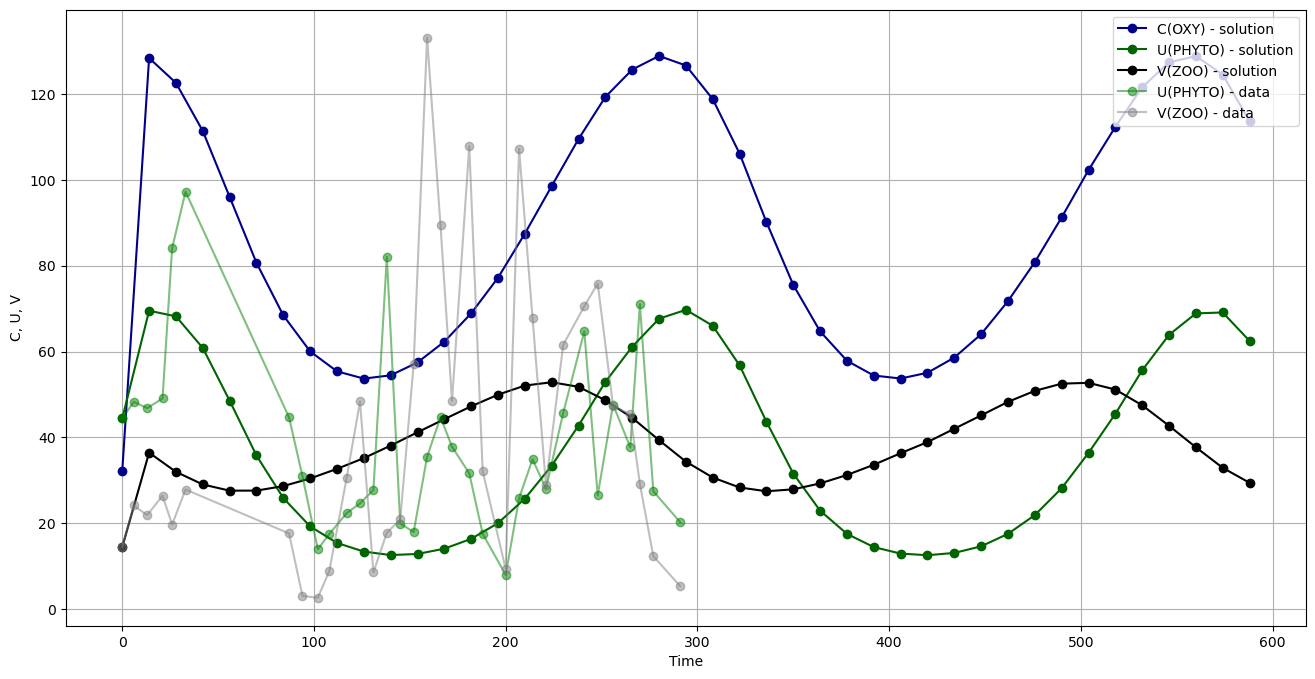

In [96]:
shower.show_solution_and_data_without_oxy(solution_new, data)

In [ ]:
# 1. Строить все графики отдельно


# 2. Сейчас выявляем сезонную зависимость параметров - на 3 месяцах (июль-август-сентябрь),
# мб сравнить параметры, которые там получатся с параметрами, которые были получены при решении на годе;
# если будет получаться постоянное решение - попробовать регуляризацию на постоянство решения;



# 3. Гипотеза - регуляризация постоянства решения - можно попробовать смотреть в некоторой окрестности 
# НЕ около 0 N точек, если все одно значение имеют, то штрафуем на 1млн


# 4. Попробовать нормировать данные на 100, прогнать решение, на исходных границах поиска,
# затем мб снизить границы поиска


